# Latent space analysis - right hemisphere

In [24]:
# Imports
import torch
import pandas as pd
#from preprocessing import create_aims_set
from vae import *
from sklearn import metrics
import datasets

In [14]:
side='R'
data_dir = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/simple_combined/'

## Loading of the model

In [12]:
root_dir ='/neurospin/dico/lguillon/midl_22/run_2/'
model = VAE((1, 12, 48, 48), 75, depth=3)
model.load_state_dict(torch.load(root_dir + 'checkpoint.pt'))

<All keys matched successfully>

## Analysis

### Loading of test data

In [15]:
# fetch data 
test_csv = '/neurospin/dico/data/deep_folding/current/test.csv'
test_list = pd.read_csv(test_csv, header=None, usecols=[0], names=['subjects'])
test_list['subjects'] = test_list['subjects'].astype('str')

# encode data
tmp = pd.read_pickle(os.path.join(data_dir, f"{side}skeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')

tmp = tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')
#tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')
filenames = list(test_list.subjects)
test_set = datasets.SkeletonDataset(dataframe=tmp, filenames=filenames)

In [16]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                          shuffle=True, num_workers=0)

dico_set_loaders = {'test': test_loader}

In [17]:
device = torch.device("cuda", index=0)
model = model.to(device)

class_weights = torch.FloatTensor([2, 7]).to(device)
#class_weights = torch.FloatTensor([2, 7])
distance = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')

# HCP -------- dataset_test_loader & benchmark
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=distance, kl_weight=2, n_latent=125,
                     depth=3, skeleton=True, root_dir=root_dir)

results = tester.test()

losses = {loader_name:[results[loader_name][k][0] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
encoded = {loader_name:[results[loader_name][k][3] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

In [18]:
df_encoded = pd.DataFrame()

df_encoded['latent'] = encoded['test']

X = np.array(list(df_encoded['latent']))

In [19]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)

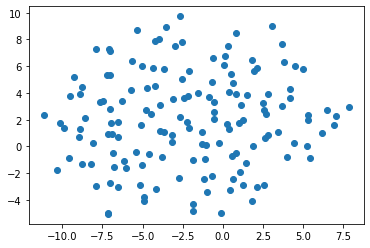

In [20]:
X_embedded = TSNE(n_components=2).fit_transform(X)
color_dict = {'test': 'blue', 'benchmark': 'magenta'}

x = [X_embedded[k][0] for k in range(150)]
y = [X_embedded[k][1] for k in range(150)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
    
plt.show()

In [ ]:
# Kmeans
from sklearn.cluster import KMeans
kmeans2d = KMeans(n_clusters=2, random_state=0).fit_predict(X_embedded)
metrics.silhouette_score(X_embedded, kmeans2d)

In [31]:
kmeans2d

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int32)

In [30]:
['red' if kmeans2d[k]==0 else 'green' for k in range(len(kmeans2d))]

['green',
 'red',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green',
 'red',
 'green',
 'red',
 'green',
 'green',
 'red',
 'red',
 'red',
 'green',
 'green',
 'red',
 'red',
 'red',
 'green',
 'green',
 'red',
 'red',
 'red',
 'green',
 'green',
 'red',
 'red',
 'red',
 'green',
 'green',
 'red',
 'red',
 'green',
 'green',
 'red',
 'green',
 'green',
 'green',
 'red',
 'red',
 'green',
 'red',
 'green',
 'green',
 'red',
 'green',
 'green',
 'red',
 'green',
 'green',
 'green',
 'green',
 'green',
 'red',
 'red',
 'red',
 'red',
 'red',
 'green',
 'red',
 'green',
 'green',
 'green',
 'green',
 'green',
 'red',
 'green',
 'green',
 'green',
 'red',
 'red',
 'green',
 'green',
 'red',
 'red',
 'green',
 'red',
 'red',
 'green',
 'green',
 'green',
 'red',
 'green',
 'red',
 'red',
 'red',
 'green',
 'red',
 'green',
 'red',
 'green',
 'red',
 'green',
 'red',
 'red',
 'red',
 'green',
 'red',
 'green',
 'red',
 'red',
 'red',
 'green',
 'red',
 'green',
 'red',
 're

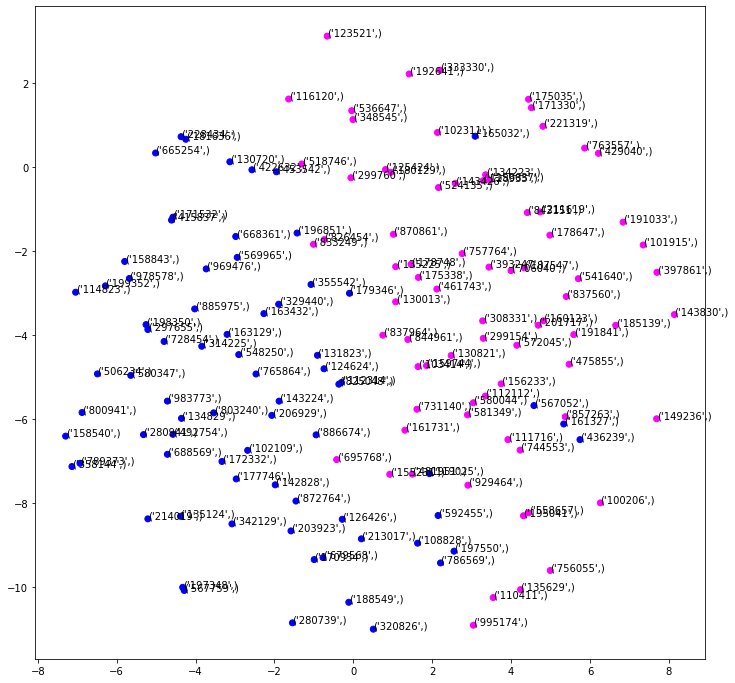

In [36]:
X_embedded = TSNE(n_components=2).fit_transform(X)
color_dict = {'test': 'blue', 'benchmark': 'magenta'}

x = [X_embedded[k][0] for k in range(150)]
y = [X_embedded[k][1] for k in range(150)]

col = ['blue' if kmeans2d[k]==0 else 'magenta' for k in range(len(kmeans2d))]

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(x, y, c=col)

n = list(results['test'].keys()) 
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

In [277]:
# Kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X)

In [278]:
from sklearn import metrics
metrics.silhouette_score(X, kmeans)

0.038734876

In [145]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=10, min_samples=5).fit_predict(X)
#metrics.silhouette_score(X, clustering)

In [146]:
clustering

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [117]:
metrics.silhouette_score(X, clustering)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)